In [1]:
import os

from tqdm import tqdm
import torch
import pandas as pd
import torchvision
from torchsampler import ImbalancedDatasetSampler
import random

In [2]:
# optimizers flags
torch.backends.cudnn.benchmark = True

# hyberparams
BATCH_SIZE = 200
NUM_WORKERS = os.cpu_count()

In [3]:
import torch
from tqdm import tqdm

class Trainer:
    def __init__(self, model, loss_fn, optimizer, scheduler=None):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler  
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        self.best_accuracy = 0

    def train(self, dataloader, epochs, test_loader):
        dataloader.dataset.is_augms = True
        size = len(dataloader.dataset)
        
        for epoch in range(epochs):
            self.model.train()
            total_loss = 0
            total_accuracy = 0
            
            for X, y in tqdm(dataloader):
                X, y = X.to(device), y.to(device)
                self.optimizer.zero_grad(set_to_none=True)
                output = self.model(X)
                loss = self.loss_fn(output, y)
                loss.backward()
                self.optimizer.step()

                total_loss += loss.item()
                total_accuracy += output.argmax(1).eq(y).float().sum().item()

            self.train_losses.append(total_loss / size)
            self.train_accuracies.append(total_accuracy / size)
            print(f"Epoch {epoch + 1}, Training Loss: {total_loss / size}, Training Accuracy: {total_accuracy / size}")

            self.eval(test_loader)

    def eval(self, dataloader):
        dataloader.dataset.is_augms = False
        self.model.eval()
        total_loss = 0
        total_accuracy = 0

        with torch.no_grad(): 
            for X, y in tqdm(dataloader):
                X, y = X.to(device), y.to(device)
                output = self.model(X)
                loss = self.loss_fn(output, y)
                total_loss += loss.item()
                total_accuracy += output.argmax(1).eq(y).float().sum().item()

        self.val_losses.append(total_loss / len(dataloader))
        self.val_accuracies.append(total_accuracy / len(dataloader.dataset))
        
        if self.scheduler:
            self.scheduler.step(total_accuracy / len(dataloader.dataset))

        if self.best_accuracy < total_accuracy / len(dataloader.dataset):
            self.best_accuracy = total_accuracy / len(dataloader.dataset)
            PATH = "mobileV2.pt"
            print('Model improved and saved.')
            torch.save(self.model.state_dict(), PATH)

        print(
            f"Validation Loss: {total_loss / len(dataloader)}, Validation Accuracy: {total_accuracy / len(dataloader.dataset)}")


In [4]:
import collections
import warnings
from itertools import repeat
from types import FunctionType
from typing import Any
from typing import Callable, List, Optional, Sequence, Tuple, Union

import torch
from torch import nn, Tensor


def _make_ntuple(x: Any, n: int) -> Tuple[Any, ...]:
    """
    Make n-tuple from input x. If x is an iterable, then we just convert it to tuple.
    Otherwise, we will make a tuple of length n, all with value of x.
    reference: https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/utils.py#L8

    Args:
        x (Any): input value
        n (int): length of the resulting tuple
    """
    if isinstance(x, collections.abc.Iterable):
        return tuple(x)
    return tuple(repeat(x, n))

def _make_divisible(v: float, divisor: int, min_value: Optional[int] = None) -> int:
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


def _log_api_usage_once(obj: Any) -> None:

    """
    Logs API usage(module and name) within an organization.
    In a large ecosystem, it's often useful to track the PyTorch and
    TorchVision APIs usage. This API provides the similar functionality to the
    logging module in the Python stdlib. It can be used for debugging purpose
    to log which methods are used and by default it is inactive, unless the user
    manually subscribes a logger via the `SetAPIUsageLogger method <https://github.com/pytorch/pytorch/blob/eb3b9fe719b21fae13c7a7cf3253f970290a573e/c10/util/Logging.cpp#L114>`_.
    Please note it is triggered only once for the same API call within a process.
    It does not collect any data from open-source users since it is no-op by default.
    For more information, please refer to
    * PyTorch note: https://pytorch.org/docs/stable/notes/large_scale_deployments.html#api-usage-logging;
    * Logging policy: https://github.com/pytorch/vision/issues/5052;

    Args:
        obj (class instance or method): an object to extract info from.
    """
    module = obj.__module__
    if not module.startswith("torchvision"):
        module = f"torchvision.internal.{module}"
    name = obj.__class__.__name__
    if isinstance(obj, FunctionType):
        name = obj.__name__
    torch._C._log_api_usage_once(f"{module}.{name}")


class ConvNormActivation(torch.nn.Sequential):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: Union[int, Tuple[int, ...]] = 3,
        stride: Union[int, Tuple[int, ...]] = 1,
        padding: Optional[Union[int, Tuple[int, ...], str]] = None,
        groups: int = 1,
        norm_layer: Optional[Callable[..., torch.nn.Module]] = torch.nn.BatchNorm2d,
        activation_layer: Optional[Callable[..., torch.nn.Module]] = torch.nn.ReLU,
        dilation: Union[int, Tuple[int, ...]] = 1,
        inplace: Optional[bool] = True,
        bias: Optional[bool] = None,
        conv_layer: Callable[..., torch.nn.Module] = torch.nn.Conv2d,
    ) -> None:

        if padding is None:
            if isinstance(kernel_size, int) and isinstance(dilation, int):
                padding = (kernel_size - 1) // 2 * dilation
            else:
                _conv_dim = len(kernel_size) if isinstance(kernel_size, Sequence) else len(dilation)
                kernel_size = _make_ntuple(kernel_size, _conv_dim)
                dilation = _make_ntuple(dilation, _conv_dim)
                padding = tuple((kernel_size[i] - 1) // 2 * dilation[i] for i in range(_conv_dim))
        if bias is None:
            bias = norm_layer is None

        layers = [
            conv_layer(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                dilation=dilation,
                groups=groups,
                bias=bias,
            )
        ]

        if norm_layer is not None:
            layers.append(norm_layer(out_channels))

        if activation_layer is not None:
            params = {} if inplace is None else {"inplace": inplace}
            layers.append(activation_layer(**params))
        super().__init__(*layers)
        _log_api_usage_once(self)
        self.out_channels = out_channels

        if self.__class__ == ConvNormActivation:
            warnings.warn(
                "Don't use ConvNormActivation directly, please use Conv2dNormActivation and Conv3dNormActivation instead."
            )


class Conv2dNormActivation(ConvNormActivation):
    """
    Configurable block used for Convolution2d-Normalization-Activation blocks.

    Args:
        in_channels (int): Number of channels in the input image
        out_channels (int): Number of channels produced by the Convolution-Normalization-Activation block
        kernel_size: (int, optional): Size of the convolving kernel. Default: 3
        stride (int, optional): Stride of the convolution. Default: 1
        padding (int, tuple or str, optional): Padding added to all four sides of the input. Default: None, in which case it will be calculated as ``padding = (kernel_size - 1) // 2 * dilation``
        groups (int, optional): Number of blocked connections from input channels to output channels. Default: 1
        norm_layer (Callable[..., torch.nn.Module], optional): Norm layer that will be stacked on top of the convolution layer. If ``None`` this layer won't be used. Default: ``torch.nn.BatchNorm2d``
        activation_layer (Callable[..., torch.nn.Module], optional): Activation function which will be stacked on top of the normalization layer (if not None), otherwise on top of the conv layer. If ``None`` this layer won't be used. Default: ``torch.nn.ReLU``
        dilation (int): Spacing between kernel elements. Default: 1
        inplace (bool): Parameter for the activation layer, which can optionally do the operation in-place. Default ``True``
        bias (bool, optional): Whether to use bias in the convolution layer. By default, biases are included if ``norm_layer is None``.

    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: Union[int, Tuple[int, int]] = 3,
        stride: Union[int, Tuple[int, int]] = 1,
        padding: Optional[Union[int, Tuple[int, int], str]] = None,
        groups: int = 1,
        norm_layer: Optional[Callable[..., torch.nn.Module]] = torch.nn.BatchNorm2d,
        activation_layer: Optional[Callable[..., torch.nn.Module]] = torch.nn.ReLU,
        dilation: Union[int, Tuple[int, int]] = 1,
        inplace: Optional[bool] = True,
        bias: Optional[bool] = None,
    ) -> None:

        super().__init__(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            groups,
            norm_layer,
            activation_layer,
            dilation,
            inplace,
            bias,
            torch.nn.Conv2d,
        )


class InvertedResidual(nn.Module):
    def __init__(
        self, inp: int, oup: int, stride: int, expand_ratio: int, norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super().__init__()
        self.stride = stride
        if stride not in [1, 2]:
            raise ValueError(f"stride should be 1 or 2 instead of {stride}")

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        hidden_dim = int(round(inp * expand_ratio))
        self.use_res_connect = self.stride == 1 and inp == oup

        layers: List[nn.Module] = []
        if expand_ratio != 1:
            # pw
            layers.append(
                Conv2dNormActivation(inp, hidden_dim, kernel_size=1, norm_layer=norm_layer, activation_layer=nn.ReLU6)
            )
        layers.extend(
            [
                # dw
                Conv2dNormActivation(
                    hidden_dim,
                    hidden_dim,
                    stride=stride,
                    groups=hidden_dim,
                    norm_layer=norm_layer,
                    activation_layer=nn.ReLU6,
                ),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                norm_layer(oup),
            ]
        )
        self.conv = nn.Sequential(*layers)
        self.out_channels = oup
        self._is_cn = stride > 1

    def forward(self, x: Tensor) -> Tensor:
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV2(nn.Module):
    def __init__(
        self,
        num_classes: int = 1000,
        width_mult: float = 1.0,
        inverted_residual_setting: Optional[List[List[int]]] = None,
        round_nearest: int = 8,
        block: Optional[Callable[..., nn.Module]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        dropout: float = 0.2,
    ) -> None:
        """
        MobileNet V2 main class

        Args:
            num_classes (int): Number of classes
            width_mult (float): Width multiplier - adjusts number of channels in each layer by this amount
            inverted_residual_setting: Network structure
            round_nearest (int): Round the number of channels in each layer to be a multiple of this number
            Set to 1 to turn off rounding
            block: Module specifying inverted residual building block for mobilenet
            norm_layer: Module specifying the normalization layer to use
            dropout (float): The droupout probability

        """
        super().__init__()
        _log_api_usage_once(self)

        if block is None:
            block = InvertedResidual

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        input_channel = 32
        last_channel = 1280

        if inverted_residual_setting is None:
            inverted_residual_setting = [
                # t, c, n, s
                [1, 16, 1, 1],
                [6, 24, 2, 2],
                [6, 32, 3, 2],
                [6, 64, 4, 2],
                [6, 96, 3, 1],
                [6, 160, 3, 2],
                [6, 320, 1, 1],
            ]

        # only check the first element, assuming user knows t,c,n,s are required
        if len(inverted_residual_setting) == 0 or len(inverted_residual_setting[0]) != 4:
            raise ValueError(
                f"inverted_residual_setting should be non-empty or a 4-element list, got {inverted_residual_setting}"
            )

        # building first layer
        input_channel = _make_divisible(input_channel * width_mult, round_nearest)
        self.last_channel = _make_divisible(last_channel * max(1.0, width_mult), round_nearest)
        features: List[nn.Module] = [
            Conv2dNormActivation(3, input_channel, stride=2, norm_layer=norm_layer, activation_layer=nn.ReLU6)
        ]
        # building inverted residual blocks
        for t, c, n, s in inverted_residual_setting:
            output_channel = _make_divisible(c * width_mult, round_nearest)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(block(input_channel, output_channel, stride, expand_ratio=t, norm_layer=norm_layer))
                input_channel = output_channel
        # building last several layers
        features.append(
            Conv2dNormActivation(
                input_channel, self.last_channel, kernel_size=1, norm_layer=norm_layer, activation_layer=nn.ReLU6
            )
        )
        # make it nn.Sequential
        self.features = nn.Sequential(*features)

        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(self.last_channel, num_classes),
        )

        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # This exists since TorchScript doesn't support inheritance, so the superclass method
        # (this one) needs to have a name other than `forward` that can be accessed in a subclass
        x = self.features(x)
        # Cannot use "squeeze" as batch-size can be 1
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    @torch.inference_mode
    def inference(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

In [5]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [21]:
model = MobileNetV2(num_classes=20).to(device)
model.load_state_dict(torch.load('best_mobile (10).pt', map_location=device, weights_only=True))

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


<All keys matched successfully>

In [22]:
# model.load_state_dict(torch.load("best_mobile.pt", map_location=device, weights_only=False))
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = torch.nn.functional.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

In [23]:
import torch.optim as optim
import torch
import torchvision
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import gc

# loss_fn = nn.CrossEntropy
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)
trainer = Trainer(model, loss_fn, optimizer, scheduler)


class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data_frame, images_dir, augmentations_dict, transforms, max_augmentations=2000):
        super().__init__()
        self.transforms = transforms  # Список аугментаций
        self.data = []
        self.labels = []
        self.augmentations_dict = augmentations_dict
        self.max_augmentations = max_augmentations

        def load_image(row):
            img_path = f"{images_dir}{row['img_id']}.jpg"
            target = int(row['target_feature'])
            image = torchvision.io.read_image(img_path).float() / 255.0
            
            # Применяем аугментации
            augmented_images = [self.transforms[0](image)]
            if self.transforms:
                num_augmentations = self.augmentations_dict[target]
                count_a = 1
                if num_augmentations>1:
                    while count_a != num_augmentations:
                        for transform in self.transforms[1:]:  # Применяем каждую аугментацию из списка
                            augmented_image = transform(image)
                            augmented_images.append(augmented_image)
                            count_a += 1
                            if count_a == num_augmentations:
                                break

            return augmented_images, [torch.tensor(target)] * len(augmented_images)

        with ThreadPoolExecutor() as executor:
            futures = {executor.submit(load_image, row): row for _, row in data_frame.iterrows()}
            for future in tqdm(futures.keys(), desc='Loading images'):
                augmented_images, targets = future.result()
                self.data.extend(augmented_images)
                self.labels.extend(targets)

    def __len__(self):
        return len(self.data)
    
    def get_labels(self):
        return [label.item() for label in self.labels]

    def __getitem__(self, idx):
        image, label = self.data[idx], self.labels[idx]

        # Ensure all images are of the same size
        if image.size(1) != 224 or image.size(2) != 224:
            print(f"Image size mismatch: {image.size()} at index {idx}")

        return image, label

 
torch.save(model.state_dict(), "model.pth")

In [24]:
import torchvision.transforms as transforms

transformx = torchvision.transforms.Compose([
    transforms.Resize((224, 224), antialias=True),  # Изменяем размер изображений для ResNet
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Нормализация под ResNet
])

transformx1 = torchvision.transforms.Compose([
    transforms.Resize((224, 224), antialias=True), 
    torchvision.transforms.RandomHorizontalFlip(p=1.0),# Изменяем размер изображений для ResNet
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Нормализация под ResNet
])

transformx2 = torchvision.transforms.Compose([
    transforms.Resize((224, 224), antialias=True), 
    torchvision.transforms.RandomRotation(degrees=30),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Нормализация под ResNet
])

transformx3 = torchvision.transforms.Compose([
    transforms.Resize((224, 224), antialias=True), 
    torchvision.transforms.RandomRotation(degrees=30),
    torchvision.transforms.RandomHorizontalFlip(p=1.0),
    torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Нормализация под ResNet
])

transformx4 = torchvision.transforms.Compose([
    transforms.Resize((224, 224), antialias=True), 
    torchvision.transforms.RandomRotation(degrees=30),
    torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Нормализация под ResNet
])

transformx5 = transforms.Compose([
    transforms.Resize((224, 224), antialias=True), 
    torchvision.transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Нормализация под ResNet
])

transformx6 = transforms.Compose([
    transforms.Resize((224, 224), antialias=True), 
    torchvision.transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
    torchvision.transforms.RandomHorizontalFlip(p=1.0),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Нормализация под ResNet
])

transformx7 = transforms.Compose([
    transforms.Resize((224, 224), antialias=True),  # Изменяем размер изображений для ResNet
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Случайные аффинные преобразования
    transforms.RandomHorizontalFlip(p=1.0),  # Случайное горизонтальное отражение
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Нормализация под ResNet
])

transformx8 = transforms.Compose([
    transforms.Resize((224, 224), antialias=True),  # Изменяем размер изображений для ResNet
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Случайные аффинные преобразования
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Нормализация под ResNet
])

In [10]:
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("human_poses_data/train_answers.csv")
train_data, test_data = train_test_split(data, test_size=0.15, stratify=data['target_feature'])

In [11]:
counts = train_data['target_feature'].value_counts()
counts = 2000/counts
counts = counts.round().astype(int).to_dict()
counts = {key: 10 for key in range(21)}
counts

{0: 8,
 1: 8,
 2: 8,
 3: 8,
 4: 8,
 5: 8,
 6: 8,
 7: 8,
 8: 8,
 9: 8,
 10: 8,
 11: 8,
 12: 8,
 13: 8,
 14: 8,
 15: 8,
 16: 8,
 17: 8,
 18: 8,
 19: 8,
 20: 8}

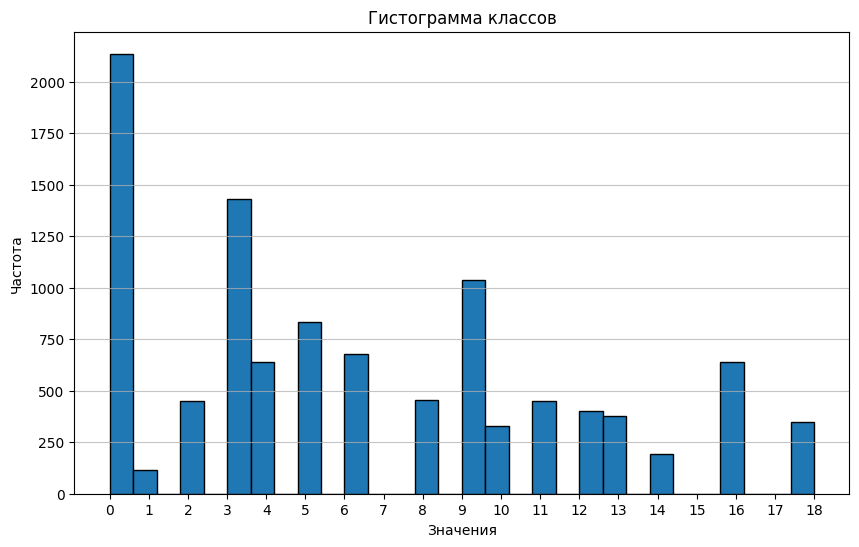

In [12]:
plt.figure(figsize=(10, 6))
train_data['target_feature'].plot.hist(bins=30, edgecolor='black')

# Настройка оси X для отображения только целых чисел
plt.xticks(range(int(data['target_feature'].min()), int(data['target_feature'].max()) + 1))

# Отображение гистограммы
plt.title('Гистограмма классов')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [13]:
from concurrent.futures import ThreadPoolExecutor

img_base = CustomDataset(train_data, "human_poses_data/img_train/", counts, [transformx, transformx1, transformx2, transformx3,transformx4,transformx5,transformx6,transformx7,transformx8])

Loading images: 100%|██████████| 10511/10511 [10:24<00:00, 16.83it/s]


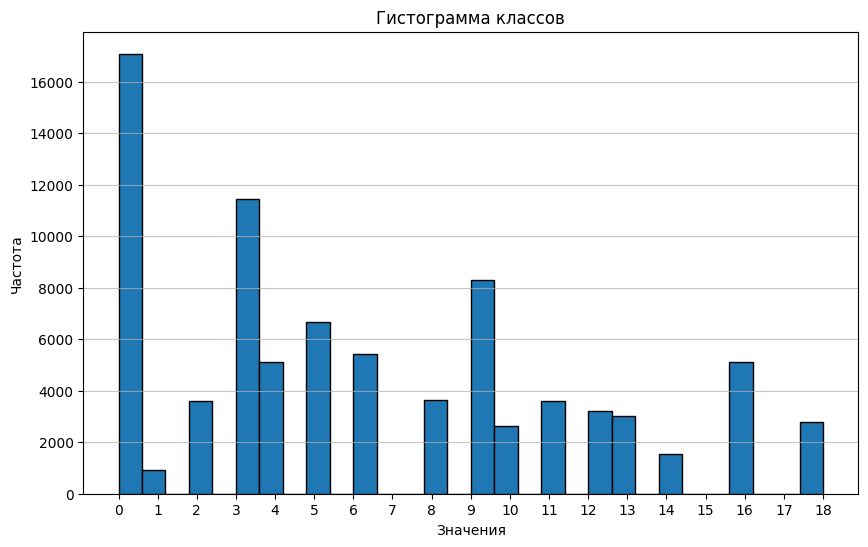

In [14]:
plt.figure(figsize=(10, 6))
plt.hist(img_base.labels, bins=30, edgecolor='black')

plt.xticks(range(int(data['target_feature'].min()), int(data['target_feature'].max()) + 1))

plt.title('Гистограмма классов')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [15]:
class CustomDataset2(torch.utils.data.Dataset):
    def __init__(self, data_frame, images_dir, transform=None):
        super().__init__()
        self.transform = transform
        self.data = []
        self.labels = []

        def load_image(row):
            img_path = f"{images_dir}{row['img_id']}.jpg"
            target = int(row['target_feature'])
            image = torchvision.io.read_image(img_path).float() / 255.0

            if self.transform:
                image = self.transform(image)

            return image, torch.tensor(target)

        with ThreadPoolExecutor() as executor:
            futures = {executor.submit(load_image, row): row for _, row in data_frame.iterrows()}
            for future in tqdm(futures.keys(), desc='Loading images'):
                image, target = future.result()
                self.data.append(image)
                self.labels.append(target)

    def __len__(self):
        return len(self.data)
    
    def get_labels(self):
        return [label.item() for label in self.labels]

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [16]:
train_dataset = img_base
val_dataset = CustomDataset2(test_data, "human_poses_data/img_train/", transformx)

Loading images: 100%|██████████| 1856/1856 [00:13<00:00, 135.07it/s]


In [25]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=300, shuffle=True, num_workers=NUM_WORKERS,
                                           pin_memory=True)
test_loader = torch.utils.data.DataLoader(val_dataset, batch_size=300, num_workers=NUM_WORKERS, pin_memory=True)

In [26]:
torch.cuda.empty_cache()

In [27]:
NUM_EPOCH = 50
trainer.train(train_loader, NUM_EPOCH, test_loader)

100%|██████████| 281/281 [01:56<00:00,  2.42it/s]


Epoch 1, Training Loss: 0.0005338572215736508, Training Accuracy: 0.9507539720293027


100%|██████████| 7/7 [00:09<00:00,  1.29s/it]

Model improved and saved.


Validation Loss: 0.04148734627025468, Validation Accuracy: 0.9881465517241379


100%|██████████| 281/281 [01:54<00:00,  2.46it/s]


Epoch 2, Training Loss: 0.0001280641852731039, Training Accuracy: 0.9898677575872895


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


Validation Loss: 0.04245061959539141, Validation Accuracy: 0.9865301724137931


100%|██████████| 281/281 [01:54<00:00,  2.46it/s]


Epoch 3, Training Loss: 7.79177798351216e-05, Training Accuracy: 0.9935543716106936


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


Validation Loss: 0.09101886807807855, Validation Accuracy: 0.9709051724137931


100%|██████████| 281/281 [01:54<00:00,  2.46it/s]


Epoch 4, Training Loss: 0.00011418829751782663, Training Accuracy: 0.9887023118637618


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Validation Loss: 0.08997547466840063, Validation Accuracy: 0.9752155172413793


100%|██████████| 281/281 [01:54<00:00,  2.46it/s]


Epoch 5, Training Loss: 9.881212799720825e-05, Training Accuracy: 0.9905337265721625


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


Validation Loss: 0.1667104001556124, Validation Accuracy: 0.9515086206896551


100%|██████████| 281/281 [01:54<00:00,  2.46it/s]


Epoch 6, Training Loss: 0.00011381472943333129, Training Accuracy: 0.9887974502901722


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


Validation Loss: 0.14267405548266002, Validation Accuracy: 0.9547413793103449


100%|██████████| 281/281 [01:54<00:00,  2.46it/s]


Epoch 7, Training Loss: 7.617544224839731e-05, Training Accuracy: 0.992162972124441


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


Epoch 00007: reducing learning rate of group 0 to 5.0000e-04.
Validation Loss: 0.1300136617251805, Validation Accuracy: 0.9552801724137931


100%|██████████| 281/281 [01:54<00:00,  2.46it/s]


Epoch 8, Training Loss: 1.951357944697033e-05, Training Accuracy: 0.9983350775378175


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


Validation Loss: 0.08981735152857644, Validation Accuracy: 0.9709051724137931


100%|██████████| 281/281 [01:54<00:00,  2.46it/s]


Epoch 9, Training Loss: 5.662426114222476e-06, Training Accuracy: 0.99972647702407


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


Validation Loss: 0.07396326373730387, Validation Accuracy: 0.9725215517241379


100%|██████████| 281/281 [01:54<00:00,  2.46it/s]


Epoch 10, Training Loss: 3.5179055640276705e-06, Training Accuracy: 0.9998097231471792


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


Validation Loss: 0.06898531796676773, Validation Accuracy: 0.9779094827586207


100%|██████████| 281/281 [01:54<00:00,  2.46it/s]


Epoch 11, Training Loss: 2.4108318540763566e-06, Training Accuracy: 0.9998810769669869


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


Validation Loss: 0.06613969856074878, Validation Accuracy: 0.9773706896551724


100%|██████████| 281/281 [01:54<00:00,  2.46it/s]


Epoch 12, Training Loss: 2.5980060979322363e-06, Training Accuracy: 0.9998454000570831


100%|██████████| 7/7 [00:08<00:00,  1.27s/it]


Validation Loss: 0.06503356939979962, Validation Accuracy: 0.9806034482758621


 52%|█████▏    | 145/281 [01:04<01:00,  2.25it/s]


KeyboardInterrupt: 

In [31]:
model.load_state_dict(torch.load('mobileV2.pt', map_location=device, weights_only=True))
trainer.train(train_loader, NUM_EPOCH, test_loader)

100%|██████████| 281/281 [01:54<00:00,  2.45it/s]


Epoch 1, Training Loss: 2.9158930551373813e-06, Training Accuracy: 0.9997502616306726


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


Epoch 00013: reducing learning rate of group 0 to 2.5000e-04.
Validation Loss: 0.07193114502089364, Validation Accuracy: 0.9779094827586207


100%|██████████| 281/281 [01:54<00:00,  2.46it/s]


Epoch 2, Training Loss: 2.3993795080402583e-06, Training Accuracy: 0.9998572923603843


100%|██████████| 7/7 [00:09<00:00,  1.29s/it]


Validation Loss: 0.06724340468645096, Validation Accuracy: 0.9800646551724138


100%|██████████| 281/281 [01:54<00:00,  2.46it/s]


Epoch 3, Training Loss: 1.4108447697104635e-06, Training Accuracy: 0.9998572923603843


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


Validation Loss: 0.06702462849872452, Validation Accuracy: 0.9789870689655172


100%|██████████| 281/281 [01:54<00:00,  2.46it/s]


Epoch 4, Training Loss: 1.4279079182238495e-06, Training Accuracy: 0.9998929692702883


100%|██████████| 7/7 [00:08<00:00,  1.26s/it]


Validation Loss: 0.06579784569995743, Validation Accuracy: 0.9827586206896551


  0%|          | 0/281 [00:00<?, ?it/s]Exception ignored in: <function _releaseLock at 0x7f1149698f70>
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 228, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
  4%|▎         | 10/281 [00:10<04:46,  1.06s/it]


KeyboardInterrupt: 

In [ ]:
model.load_state_dict(torch.load('mobileV2.pt', map_location=device, weights_only=True))
trainer.train(train_loader, NUM_EPOCH, test_loader)

100%|██████████| 281/281 [01:57<00:00,  2.39it/s]


Epoch 1, Training Loss: 9.808389447311578e-07, Training Accuracy: 0.9999286461801922


100%|██████████| 7/7 [00:08<00:00,  1.26s/it]


Validation Loss: 0.06483292579650879, Validation Accuracy: 0.9811422413793104


100%|██████████| 281/281 [01:57<00:00,  2.39it/s]


Epoch 2, Training Loss: 1.5652273271579358e-06, Training Accuracy: 0.9998691846636857


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


Validation Loss: 0.06585256648915154, Validation Accuracy: 0.9822198275862069


100%|██████████| 281/281 [01:54<00:00,  2.45it/s]


Epoch 3, Training Loss: 1.3995095631914072e-06, Training Accuracy: 0.9998810769669869


  0%|          | 0/7 [00:00<?, ?it/s]

In [33]:
PATH = "mobileV2.pt"
print('Model improved and saved.')
torch.save(trainer.model.state_dict(), PATH)

Model improved and saved.
